**Find the Optimal Hampel Filters**

# Imports

## Libraries

In [127]:
import os
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
import librosa
import numba 
from numba import jit
import warnings # from https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
from functions import *
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns

## Data

In [2]:
cwd = os.getcwd()
corrected_textgrid_names_list = glob.glob(cwd + "/corrected_textgrid/*ENF_0?TextGrid")

In [3]:
corrected_textgrid_names_list

['/Users/gregfeliu/Desktop/Flatiron Bootcamp/Vowel Identifier/corrected_textgrid/ENF_06TextGrid',
 '/Users/gregfeliu/Desktop/Flatiron Bootcamp/Vowel Identifier/corrected_textgrid/ENF_02TextGrid']

### DataFrame

In [4]:
df = pd.read_csv("combined_corrected_textgrids", index_col= 0)

In [5]:
df.head(3)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,NaN,0.000000,2.000000,NaN,0.0,2.000000,0,6,2.000000
1,!SIL,2.000000,4.589832,!SIL,2.0,4.361218,0,6,2.589832
2,AH,4.589832,4.831125,!SIL,2.0,4.361218,1,6,0.241293


### Audio

For this notebook, the main focus will be identifying the optimal parameters for the hampel filter, using the corrected textgrids from speakers ENF_02 and ENF_06. In order to optimize the amount of processing and time needed to find these parameters, I will only be sampling the first 90 seconds of each audio file.

In [6]:
short_audio, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", duration = 90, sr = 8000)

In [7]:
len(short_audio)

720000

# Using Hampel Filter

I will use the hampel filter with a set of parameters, then evaluate how many predictions made were in a vowel interval. Additionally, I will find the recall, precision, and F1 score for that set of parameters. I will plot each of these set of parameters according to these parameters to determine which one is best.

## Building Evaluation Method

### Find all of the intervals for each speaker that are actually vowels

#### Narrowing dataframe

In [8]:
short_df = df[(df['Phone_xmax'] < 90) & (df['Vowel'] == 1)].reset_index(drop = True)

In [9]:
short_df.head(3)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293
1,AY,5.481125,5.881125,mine,5.141125,6.111125,1,6,0.400000
2,IH,6.161722,6.441125,mine,5.141125,6.111125,1,6,0.279403


#### Chunk the original audio into segments of 1/8000th of a second 

In [10]:
vowel_indices = chunk_vowels_to_sr(short_df)

##### Checking if this method worked

In [12]:
# doing this, I predict that 22 seconds of the first 90 seconds of the data are vowels
len(vowel_indices) / 8000

22.0005

In [13]:
# checking the actual duration of vowel sounds in this section of the audio 
short_df.Phone_Duration.sum()

21.97939940385457

In [14]:
# I am predicting that 24% of this section of the audio file is made up of vowel sounds. 
# Initially, I saw 12% of the audio was made up of vowel sounds
len(vowel_indices) / (90 * 8000)

0.24445

### Calculate the metrics

In [12]:
vowel_indices_binary = make_results_into_binary(vowel_indices)

## Testing Different Filters

In [30]:
# putting all results into a dataframe
metric_df = pd.DataFrame()

In [31]:
# trying all window sizes from 25 - 200
metric_df_list = []
for y in range(0, 36, 5): # 25 b/c I want 0.25 and the step has to be an integer. All cases where its used are divided by 10
    for x in range(25, 201, 25):
        single_filter_metric_dict = use_filter_and_calculate_metrics(x, (y/10), short_audio, vowel_indices_binary)
        single_filter_metric_dict['window_size'] = x
        single_filter_metric_dict['n_sigmas'] = (y/10)
        single_metric_df = pd.DataFrame.from_dict(single_filter_metric_dict, orient='index').T
        metric_df_list.append(single_metric_df)

In [32]:
all_metric_values_df = pd.concat(metric_df_list)

In [33]:
all_metric_values_df.sort_values(by='F1_score', inplace=True, ascending=False)

In [13]:
all_metric_values_df.head(5)

NameError: name 'all_metric_values_df' is not defined

In [35]:
# all_metric_values_df.to_csv("First_round_of_hampel_filter_values.csv")

Couple of conclusions from this:
- The maximum F1_score we can get from this is 0.42
- Having a sigma of 0 means that all cases are predicted to be vowels
- Recall (number of correct guesses) is almost always higher than precision (correctly choosing a vowel on a guess)
- The lower sigma values did much better

## Second round of testing filters

In this round of testing, we'll focus on the lower sigma values. 
For both parameters, we'll test more values

In [20]:
log_window_values = [x**4 for x in range(2, 7)]

In [21]:
# putting all results into a dataframe
metric_df2 = pd.DataFrame()

In [23]:
# trying all window sizes from 25 - 200
metric_df_list2 = []
for y in range(1, 11, 1):
    for x in log_window_values:
        single_filter_metric_dict = use_filter_and_calculate_metrics(x, (y/10), short_audio, vowel_indices_binary)
        single_filter_metric_dict['window_size'] = x
        single_filter_metric_dict['n_sigmas'] = (y/10)
        single_metric_df = pd.DataFrame.from_dict(single_filter_metric_dict, orient='index').T
        metric_df_list2.append(single_metric_df)

In [24]:
all_metric_values_df2 = pd.concat(metric_df_list2)

In [25]:
all_metric_values_df2.sort_values(by='F1_score', inplace=True, ascending=False)

In [28]:
all_metric_values_df2.head()

,F1_score,Recall,Precision,window_size,n_sigmas
0,0.436068,0.813200,0.297908,16.0,0.2
0,0.435113,0.746324,0.307068,16.0,0.3
0,0.429632,0.680919,0.313820,16.0,0.4
0,0.427297,0.888708,0.281266,16.0,0.1
0,0.423631,0.499028,0.368027,1296.0,1.0


#### Saving the dataframe

In [27]:
# all_metric_values_df2.to_csv("Second_round_of_hampel_filter_values.csv")

Final conclusions on this:
- The maximum that this method can achieve, even after manual testing is an F1 score of about 0.43

# Did the filter find all vowels? 

In the previous section, we were checking if the filter was able to find each of the samples for each vowel. This, of course, is a very precise task: it needed to find each part of the file that was a vowel to 1/8000th of a second precision. If we evaluate how many predictions were made for each of the vowels in the file, we could potentially have much better results. In other words, if there are 100 samples that are vowels, and our hampel filter finds 10 of them, according to our previous metrics it looks pretty bad. However, if it only made high-density predictions on actual vowels, this method might look a lot better.

## Counting number of predictions per vowel 

In [14]:
# new column to vowel_df that counts how many predictions were made for each vowel

### window_size 16, 0.2 sigma

In [15]:
new_series_16_2, indices_16_2 = hampel_filter_forloop_numba(short_audio, 16, 0.2)
binary_indices_16_2 = make_results_into_binary(indices_16_2)

In [44]:
short_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration
0,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293
1,AY,5.481125,5.881125,mine,5.141125,6.111125,1,6,0.400000


In [46]:
binary_indices_16_2_timepoints = []
for idx, x in enumerate(binary_indices_16_2):
    binary_indices_16_2_timepoints.append(x*idx)

In [48]:
np.array(binary_indices_16_2_timepoints).sum()

178739128949.0

In [19]:
short_df.shape[0]

170

In [49]:
prediction_counter_list = []
for x in range(short_df.shape[0]):
    predictions_in_seconds = np.array(binary_indices_16_2_timepoints) / 8000
    prediction_counter_binary = np.where((predictions_in_seconds > short_df['Phone_xmin'][x]) &
                                  (predictions_in_seconds < short_df['Phone_xmax'][x]),
                                         1, 0)
    total = prediction_counter_binary.sum()
    prediction_counter_list.append(total)

In [51]:
len(prediction_counter_list)

170

In [78]:
# the filter checks each sample, not just each one in a window
prediction_counter_list[0:10]

[1635, 2254, 1796, 1219, 673, 997, 1042, 543, 1158, 1300]

In [59]:
short_df['Sigma0.2_window16'] = prediction_counter_list

In [60]:
short_df['Percent_of_16_2_predicted'] = short_df['Sigma0.2_window16'] / (short_df['Phone_Duration'] * 8000)

In [77]:
short_df.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Sigma0.2_window16,Percent_of_16_2_predicted
0,AH,4.589832,4.831125,!SIL,2.000000,4.361218,1,6,0.241293,1635,0.847000
1,AY,5.481125,5.881125,mine,5.141125,6.111125,1,6,0.400000,2254,0.704375


#### Evaluating the success of window size 16, sigma 0.2

In [64]:
short_df['Percent_of_16_2_predicted'].min()

0.6187500000000132

In [65]:
short_df['Percent_of_16_2_predicted'].max()

0.9120826728242175

In [66]:
# So this filter predicted most of the vowel for all cases

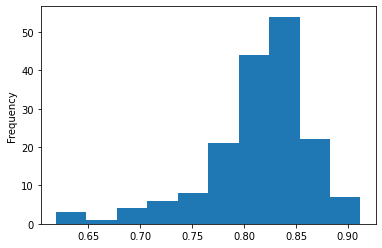

In [68]:
# visualizing the distribution of the percent correct
short_df['Percent_of_16_2_predicted'].plot(kind='hist')

In [74]:
# how many of the vowels had a prediction percentage above 70%?
short_df[short_df['Percent_of_16_2_predicted'] > 0.7].count() / short_df.shape[0]

Phone_Text                   0.964706
Phone_xmin                   0.964706
Phone_xmax                   0.964706
Word_Text                    0.964706
Word_xmin                    0.964706
Word_xmax                    0.964706
Vowel                        0.964706
Speaker                      0.964706
Phone_Duration               0.964706
Sigma0.2_window16            0.964706
Percent_of_16_2_predicted    0.964706
dtype: float64

In 96.5 % of cases, if the filter predicted at least 70% of the samples of the segment to be a vowel, it was actually a vowel. Not entirely sure what the F1 score would be for that, but I assume very high. 

What does this mean? This means that if we had a pre-segmented file for each of the speech sounds, we could find at least 96% of the vowels. One caveat to this is that we are not sure how imprecise the filter is. In other words, if it ONLY predicted vowel, this still may hold true but would be useless. Thus, I will see how this filter did on non-vowels, too.

#### Evaluating success/failure of hampel filter 

In [75]:
df_90 = df[df['Phone_xmax'] < 90].reset_index(drop = True)

In [90]:
df_90.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Sigma0.2_window16,Percent_of_16_2_predicted
0,NaN,0.0,2.000000,NaN,0.0,2.000000,0,6,2.000000,60,0.003750
1,!SIL,2.0,4.589832,!SIL,2.0,4.361218,0,6,2.589832,12284,0.592896


In [80]:
prediction_counter_list2 = []
predictions_in_seconds2 = np.array(binary_indices_16_2_timepoints) / 8000
for x in range(df_90.shape[0]):
    prediction_counter_binary2 = np.where((predictions_in_seconds2 > df_90['Phone_xmin'][x]) &
                                  (predictions_in_seconds2 < df_90['Phone_xmax'][x]),
                                         1, 0)
    total2 = prediction_counter_binary2.sum()
    prediction_counter_list2.append(total2)

In [82]:
len(prediction_counter_list2)

464

In [83]:
df_90['Sigma0.2_window16'] = prediction_counter_list2

In [84]:
df_90['Percent_of_16_2_predicted'] = df_90['Sigma0.2_window16'] / (df_90['Phone_Duration'] * 8000)

In [86]:
df_90.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speaker,Phone_Duration,Sigma0.2_window16,Percent_of_16_2_predicted
0,NaN,0.0,2.000000,NaN,0.0,2.000000,0,6,2.000000,60,0.003750
1,!SIL,2.0,4.589832,!SIL,2.0,4.361218,0,6,2.589832,12284,0.592896


In [87]:
# grouping by vowel column and getting average percent predicted
df_90_vowel_group = df_90.groupby(['Vowel']).Percent_of_16_2_predicted.mean()

In [89]:
df_90_vowel_group

Vowel
0    0.734389
1    0.813252
Name: Percent_of_16_2_predicted, dtype: float64

Conclusions:
- A low sigma, low window hampel filter isn't particularly precise in picking vowels
- There is only a slight difference in mean percent vowel-predictions for each class of speech sounds

In [103]:
# Picking a hampel filter that is more precise
metrics2 = pd.read_csv("corrected_textgrid/metrics/Second_round_of_hampel_filter_values.csv", index_col = 0)
metrics2.set_index('Precision', inplace=True)

In [112]:
metrics2.head(2)

,F1_score,Recall,window_size,n_sigmas
Precision,,,,
0.297908,0.436068,0.813200,16.0,0.2
0.307068,0.435113,0.746324,16.0,0.3


In [113]:
metrics2.sort_values(by = 'Precision', ascending=False).head(3)

,F1_score,Recall,window_size,n_sigmas
Precision,,,,
0.380554,0.346433,0.317928,16.0,1.0
0.368027,0.423631,0.499028,1296.0,1.0
0.365395,0.366200,0.367008,16.0,0.9


### window_size 1296, 1 sigma

In [114]:
# window_size 1296, 1 sigma is more precise (0.38 compared to 0.29) while having a similar f1 score

In [115]:
new_series_1296_1, indices_1296_1 = hampel_filter_forloop_numba(short_audio, 1296, 1)
binary_indices_1296_1 = make_results_into_binary(indices_1296_1)

In [116]:
binary_indices_1296_1_timepoints = []
for idx, x in enumerate(binary_indices_1296_1):
    binary_indices_1296_1_timepoints.append(x*idx)

In [118]:
prediction_counter_list3 = []
predictions_in_seconds3 = np.array(binary_indices_1296_1_timepoints) / 8000
for x in range(df_90.shape[0]):
    prediction_counter_binary3 = np.where((predictions_in_seconds3 > df_90['Phone_xmin'][x]) &
                                  (predictions_in_seconds3 < df_90['Phone_xmax'][x]),
                                         1, 0)
    total3 = prediction_counter_binary3.sum()
    prediction_counter_list3.append(total3)

In [120]:
df_90['Sigma1_window1296'] = prediction_counter_list3

In [122]:
df_90['Percent_of_1296_1_predicted'] = df_90['Sigma1_window1296'] / (df_90['Phone_Duration'] * 8000)

In [123]:
# grouping by vowel column and getting average percent predicted
df_90_vowel_group2 = df_90.groupby(['Vowel']).Percent_of_1296_1_predicted.mean()

In [124]:
df_90_vowel_group2

Vowel
0    0.322893
1    0.515288
Name: Percent_of_1296_1_predicted, dtype: float64

In [135]:
df_90_sigma1_vowel = df_90[(df_90['Vowel'] == 1)]['Percent_of_1296_1_predicted']

In [137]:
df_90_sigma1_not_vowel = df_90[(df_90['Vowel'] == 0)]['Percent_of_1296_1_predicted']

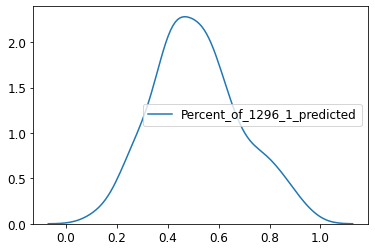

In [140]:
sns.kdeplot(df_90_sigma1_vowel)

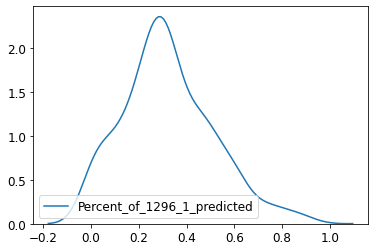

In [141]:
sns.kdeplot(df_90_sigma1_not_vowel)

Not much of a difference between the two charts, must be a lot of overlap

# Conclusion

This method probably needs larger outlier variation than what is found in speech signals. In combination with other models/methods of classification, it may help, but on its own it is not very effective. There is simply not a large enough difference between vowels and non-vowels to make this method feasible on its own. 